In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import microstructpy as msp
import meshio

In [3]:
domain = msp.geometry.Square(corner=(0, 0))

In [4]:
factory = msp.seeding.Seed.factory
n = 100
seeds = msp.seeding.SeedList([factory('circle', r=0.007) for i in range(n)])

In [5]:
lims = np.array(domain.limits) * (1 - 1e-5)
centers = np.zeros((n, 2))

for i in range(n):
    f = np.random.rand(i + 1, 2)
    pts = f * lims[:, 0] + (1 - f) * lims[:, 1]
    try:
        min_dists = scipy.spatial.distance.cdist(pts, centers[:i]).min(axis=1)
        i_max = np.argmax(min_dists)
    except ValueError:  # this is the case when i=0
        i_max = 0
    centers[i] = pts[i_max]
    seeds[i].position = centers[i]

In [6]:
pmesh = msp.meshing.PolyMesh.from_seeds(seeds, domain)
pmesh.write("microstructure.txt")

In [7]:
np.save("centers.npy", centers)

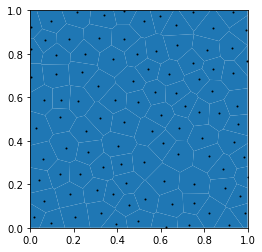

In [8]:
pmesh.plot()
plt.scatter(centers[:, 0], centers[:, 1], color='black', s=1)

In [9]:
tmesh = msp.meshing.TriMesh.from_polymesh(pmesh,
                                          min_angle=30,
                                          max_edge_length=0.01,
                                          max_volume=0.1)

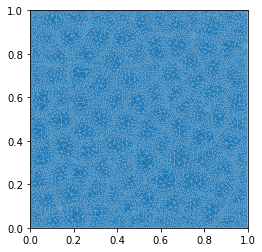

In [10]:
tmesh.plot()

In [13]:
def extract_line_elements(tmesh):
    line_elements = set()
    for triangle in tmesh.elements:
        for i in range(3):
            # Extract the vertices of each edge and sort them to ensure uniqueness
            edge = tuple(sorted([triangle[i], triangle[(i + 1) % 3]]))
            line_elements.add(edge)
    return np.vstack(list(line_elements))
line_elements = extract_line_elements(tmesh)
triangle_elements = tmesh.elements
cells_attributes = tmesh.element_attributes
points = tmesh.points

In [14]:
boundary_maps = [(1, 0, 0.0), (2, 0, 1.0), (3, 1, 0.0), (4, 1, 1.0)]
def get_boundary_elements(line_elements, points):
    line_attributes = np.zeros(line_elements.shape[0], dtype='int')
    for m, i, v in boundary_maps:
        inds = [j for j in range(line_elements.shape[0])
                if np.all(np.isclose(points[line_elements[j], i], v))]
        line_attributes[inds] = m
    return line_attributes


In [15]:
cells = [
    meshio.CellBlock("line", line_elements),
    meshio.CellBlock("triangle", triangle_elements),
]

line_attributes = get_boundary_elements(line_elements, points)
triangle_attributes = cells_attributes
cell_data_dict = {
    "grain": [  # Replace with the actual attribute name
        np.array(line_attributes),
        np.array(triangle_attributes),
    ]
}

mesh = meshio.Mesh(
    points=points,
    cells=cells,
    cell_data=cell_data_dict,
)
meshio.write("microstructure_mesh.vtk", mesh)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.